In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve, precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix

## Scaling

In [2]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv', header=None)[0]
y_test = pd.read_csv('data/y_test.csv', header=None)[0]
scaler = StandardScaler()
X_train['normAmount'] = scaler.fit_transform(np.array(X_train['Amount']).reshape(-1, 1))
X_test['normAmount'] = scaler.transform(np.array(X_test['Amount']).reshape(-1, 1))
X_train.drop(['Time', 'Amount'], axis=1, inplace=True)
X_test.drop(['Time', 'Amount'], axis=1, inplace=True)

In [3]:
X_train.drop(['V19','V8','V21','V26','V20','V1','V27','V2','V6','V28','V15','V5','V13','V22','V25','V23','V24'], axis=1, inplace=True)
X_test.drop(['V19','V8','V21','V26','V20','V1','V27','V2','V6','V28','V15','V5','V13','V22','V25','V23','V24'], axis=1, inplace=True)

In [4]:
def print_metrics(y_true, y_pred):
    print ("Precision: %.4f" % (precision_score(y_true, y_pred)))
    print ("Recall: %.4f" % (recall_score(y_true, y_pred)))
    print ("F1: %.4f" % (f1_score(y_true, y_pred)))
    print ("Confusion matrix:")
    print (confusion_matrix(y_true, y_pred))
    return

def aucpr(y_true, y_score):
    precision, recall, threshold = precision_recall_curve(y_true, y_score)
    indices = np.argsort(precision)
    precision = precision[indices]
    recall = recall[indices]
    plt.plot(recall, precision, '.')
    plt.show()
    return auc(precision, recall)

## Under sampling

In [5]:
normal_indices = y_train[y_train==0].index
fraud_indices = y_train[y_train==1].index
num_fraud = len(fraud_indices)
random_normal_indices = np.random.choice(normal_indices, num_fraud, replace=False)
undersample_indices = np.concatenate([fraud_indices, random_normal_indices])
undersample_X_train = X_train.iloc[undersample_indices, :]
undersample_y_train = y_train[undersample_indices]

## LR

In [6]:
lr = LogisticRegression(C=0.01)
lr.fit(undersample_X_train, undersample_y_train)

undersample_y_train_pred = lr.predict(undersample_X_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
print ("\n---Undersampling---")
print_metrics(undersample_y_train, undersample_y_train_pred)
print ("\n---Train---")
print_metrics(y_train, y_train_pred)
print ("\n---Test---")
print_metrics(y_test, y_test_pred)

/home/wangsun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



---Undersampling---
Precision: 0.9571
Recall: 0.9286
F1: 0.9426
Confusion matrix:
[[322  14]
 [ 24 312]]

---Train---
Precision: 0.0360
Recall: 0.9286
F1: 0.0693
Confusion matrix:
[[190674   8354]
 [    24    312]]

---Test---
Precision: 0.0370
Recall: 0.8974
F1: 0.0710
Confusion matrix:
[[81641  3646]
 [   16   140]]


## Tuning on decision function threshold

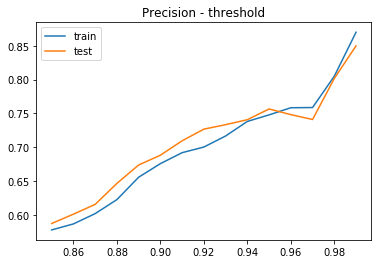

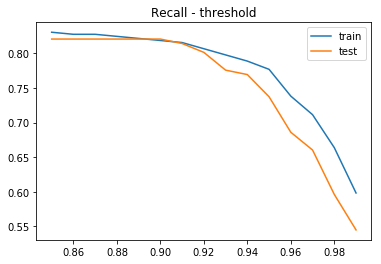

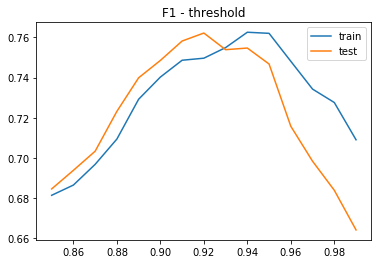

In [7]:
undersample_y_train_score = lr.predict_proba(undersample_X_train)[:, 1]
y_train_score = lr.predict_proba(X_train)[:, 1]
y_test_score = lr.predict_proba(X_test)[:, 1]
train_prec = []
test_prec = []
train_rec = []
test_rec = []
train_f1 = []
test_f1 = []
for threshold in np.arange(0.85, 0.99, 0.01):
    y_train_pred = np.array([sc>threshold for sc in y_train_score], dtype=int)
    y_test_pred = np.array([sc>threshold for sc in y_test_score], dtype=int)

    train_prec.append(precision_score(y_train, y_train_pred))
    test_prec.append(precision_score(y_test, y_test_pred))
    train_rec.append(recall_score(y_train, y_train_pred))
    test_rec.append(recall_score(y_test, y_test_pred))
    train_f1.append(f1_score(y_train, y_train_pred))
    test_f1.append(f1_score(y_test, y_test_pred))
    
plt.plot(np.arange(0.85, 0.99, 0.01), train_prec, label='train')
plt.plot(np.arange(0.85, 0.99, 0.01), test_prec, label='test')
plt.title("Precision - threshold")
plt.legend()
plt.show()
    
plt.plot(np.arange(0.85, 0.99, 0.01), train_rec, label='train')
plt.plot(np.arange(0.85, 0.99, 0.01), test_rec, label='test')
plt.title("Recall - threshold")
plt.legend()
plt.show()    

plt.plot(np.arange(0.85, 0.99, 0.01), train_f1, label='train')
plt.plot(np.arange(0.85, 0.99, 0.01), test_f1, label='test')
plt.title("F1 - threshold")
plt.legend()
plt.show()

/home/wangsun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



---Train---
Precision: 0.7479
Recall: 0.7768
F1: 0.7620
Confusion matrix:
[[198940     88]
 [    75    261]]

---Test---
Precision: 0.7566
Recall: 0.7372
F1: 0.7468
Confusion matrix:
[[85250    37]
 [   41   115]]


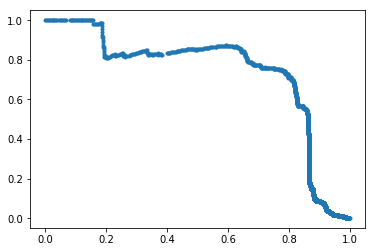

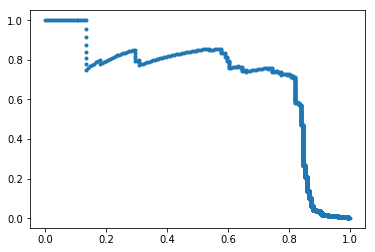

(0.7361385157487752, 0.6996178973645525)

In [8]:
lr = LogisticRegression(C=0.01)
lr.fit(undersample_X_train, undersample_y_train)
y_train_score = lr.predict_proba(X_train)[:, 1]
y_test_score = lr.predict_proba(X_test)[:, 1]
threshold = 0.95
y_train_pred = np.array([sc>threshold for sc in y_train_score], dtype=int)
y_test_pred = np.array([sc>threshold for sc in y_test_score], dtype=int)

print ("\n---Train---")
print_metrics(y_train, y_train_pred)
print ("\n---Test---")
print_metrics(y_test, y_test_pred)

aucpr(y_train, y_train_score), aucpr(y_test, y_test_score)